<a href="https://colab.research.google.com/github/AjeetSingh02/Courses/blob/master/deep_learning/Convolutional%20Neural%20Networks/Coursera_CNN_Week4_Assignment1_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition

Welcome! In this assignment, you're going to build a face recognition system. Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). In the lecture, you also encountered [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf).

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" For example, the video lecture showed a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

By the end of this assignment, you'll be able to: 

* Differentiate between face recognition and face verification
* Implement one-shot learning to solve a face recognition problem
* Apply the triplet loss function to learn a network's parameters in the context of face recognition
* Explain how to pose face recognition as a binary classification problem
* Map face images into 128-dimensional encodings using a pretrained model
* Perform face verification and face recognition with these encodings

**Channels-last notation**

For this assignment, you'll be using a pre-trained model which represents ConvNet activations using a "channels last" convention, as used during the lecture and in previous programming assignments.

In other words, a batch of images will be of shape $(m, n_H, n_W, n_C)$. 

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/convolutional-neural-networks/supplement/DS4yP/h-ow-to-refresh-your-workspace).

## Table of Contents

- [1 - Packages](#1)
- [2 - Naive Face Verification](#2)
- [3 - Encoding Face Images into a 128-Dimensional Vector](#3)
    - [3.1 - Using a ConvNet to Compute Encodings](#3-1)
    - [3.2 - The Triplet Loss](#3-2)
        - [Exercise 1 - triplet_loss](#ex-1)
- [4 - Loading the Pre-trained Model](#4)
- [5 - Applying the Model](#5)
    - [5.1 - Face Verification](#5-1)
        - [Exercise 2 - verify](#ex-2)
    - [5.2 - Face Recognition](#5-2)
        - [Exercise 3 - who_is_it](#ex-3)
- [6 - References](#6)

<a name='1'></a>
## 1 - Packages

Go ahead and run the cell below to import the packages you'll need.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 - Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images is below a chosen threshold, it may be the same person!

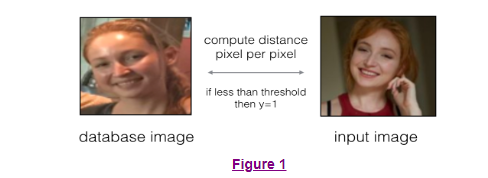

Of course, this algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, minor changes in head position, and so on.

You'll see that rather than using the raw image, you can learn an encoding, $f(img)$.

By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

<a name='3'></a>
## 3 - Encoding Face Images into a 128-Dimensional Vector

<a name='3-1'></a>
### 3.1 - Using a ConvNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, you'll load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842) An Inception network implementation has been provided for you, and you can find it in the file `inception_blocks_v2.py` to get a closer look at how it is implemented.  

*Hot tip:* Go to "File->Open..." at the top of this notebook. This opens the file directory that contains the `.py` file).

The key things to be aware of are:

- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- The input images are originally of shape 96x96, thus, you need to scale them to 160x160. This is done in the `img_to_encoding()` function.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

Run the cell below to create the model for face images!

In [ ]:
from tensorflow.keras.models import model_from_json

json_file = open('keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('keras-facenet-h5/model.h5')

Now summarize the input and output shapes: 

In [ ]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings to compare two face images as follows:

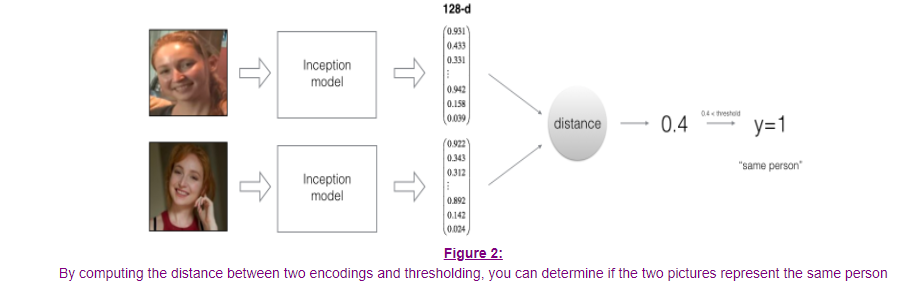

So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.
    
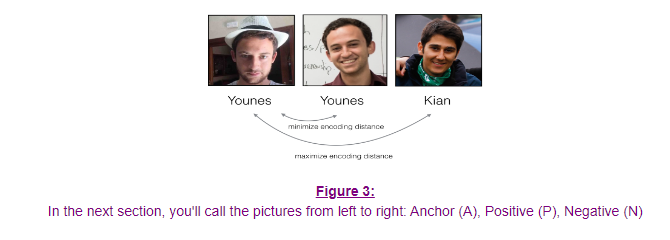

<a name='3-2'></a>
### 3.2 - The Triplet Loss

**Important Note**: Since you're using a pretrained model, you won't actually need to implement the triplet loss function in this assignment. *However*, the triplet loss is the main ingredient of the face recognition algorithm, and you'll need to know how to use it for training your own FaceNet model, as well as other types of image similarity problems. Therefore, you'll implement it below, for fun and edification. :) 

For an image $x$, its encoding is denoted as $f(x)$, where $f$ is the function computed by the neural network.

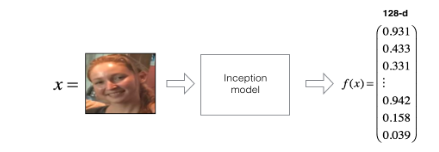

Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from the training dataset. $(A^{(i)}, P^{(i)}, N^{(i)})$ is used here to denote the $i$-th training example.

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$
|| f\left(A^{(i)}\right)-f\left(P^{(i)}\right)||_{2}^{2}+\alpha<|| f\left(A^{(i)}\right)-f\left(N^{(i)}\right)||_{2}^{2}
$$


You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$
Here, the notation "$[z]_+$" is used to denote $max(z,0)$.

**Notes**:

- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small.
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
- $\alpha$ is called the margin. It's a hyperparameter that you pick manually. You'll use $\alpha = 0.2$.

Most implementations also rescale the encoding vectors to haven L2 norm equal to one (i.e., $\mid \mid f(img)\mid \mid_2$=1); you won't have to worry about that in this assignment.

<a name='ex-1'></a>
### Exercise 1 - triplet_loss

Implement the triplet loss as defined by formula (3). These are the 4 steps:

1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
4. Compute the full formula by taking the max with zero and summing over the training examples:$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

*Hints*:

- Useful functions: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.maximum()`.

- For steps 1 and 2, sum over the entries of $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$ and $\mid \mid     f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$.

- For step 4, you will sum over the training examples.

*Additional Hints*:

- Recall that the square of the L2 norm is the sum of the squared differences: $||x - y||_{2}^{2} = \sum_{i=1}^{N}(x_{i} - y_{i})^{2}$

- Note that the anchor, positive and negative encodings are of shape (*m*,128), where *m* is the number of training examples and 128 is the number of elements used to encode a single example.

- For steps 1 and 2, maintain the number of *m* training examples and sum along the 128 values of each encoding. `tf.reduce_sum` has an axis parameter. This chooses along which axis the sums are applied.

- Note that one way to choose the last axis in a tensor is to use negative indexing (axis=-1).

- In step 4, when summing over training examples, the result will be a single scalar value.

- For `tf.reduce_sum` to sum across all axes, keep the default value axis=None.

In [ ]:
# UNQ_C1(UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE
    #(≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0), axis=None)
    ### END CODE HERE
    
    return loss

In [ ]:
# BEGIN UNIT TEST
tf.random.set_seed(1)
y_true = (None, None, None) # It is not used
y_pred = (tf.keras.backend.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=1, stddev=1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=3, stddev=4, seed = 1))
loss = triplet_loss(y_true, y_pred)

assert type(loss) == tf.python.framework.ops.EagerTensor, "Use tensorflow functions"
print("loss = " + str(loss))

y_pred_perfect = ([1., 1.], [1., 1.], [1., 1.,])
loss = triplet_loss(y_true, y_pred_perfect, 5)
assert loss == 5, "Wrong value. Did you add the alpha to basic_loss?"
y_pred_perfect = ([1., 1.],[1., 1.], [0., 0.,])
loss = triplet_loss(y_true, y_pred_perfect, 3)
assert loss == 1., "Wrong value. Check that pos_dist = 0 and neg_dist = 2 in this example"
y_pred_perfect = ([1., 1.],[0., 0.], [1., 1.,])
loss = triplet_loss(y_true, y_pred_perfect, 0)
assert loss == 2., "Wrong value. Check that pos_dist = 2 and neg_dist = 0 in this example"
y_pred_perfect = ([0., 0.],[0., 0.], [0., 0.,])
loss = triplet_loss(y_true, y_pred_perfect, -2)
assert loss == 0, "Wrong value. Are you taking the maximum between basic_loss and 0?"
y_pred_perfect = ([[1., 0.], [1., 0.]],[[1., 0.], [1., 0.]], [[0., 1.], [0., 1.]])
loss = triplet_loss(y_true, y_pred_perfect, 3)
assert loss == 2., "Wrong value. Are you applying tf.reduce_sum to get the loss?"
y_pred_perfect = ([[1., 1.], [2., 0.]], [[0., 3.], [1., 1.]], [[1., 0.], [0., 1.,]])
loss = triplet_loss(y_true, y_pred_perfect, 1)
if (loss == 4.):
    raise Exception('Perhaps you are not using axis=-1 in reduce_sum?')
assert loss == 5, "Wrong value. Check your implementation"
# END UNIT TEST

loss = tf.Tensor(527.2598, shape=(), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            <b>loss:</b>
        </td>
        <td>
           tf.Tensor(527.2598, shape=(), dtype=float32)
        </td>
    </tr>
    </table>

<a name='4'></a>
## 4 - Loading the Pre-trained Model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, you won't train it from scratch here. Instead, you'll load a previously trained model in the following cell; which might take a couple of minutes to run.

In [ ]:
FRmodel = model

Here are some examples of distances between the encodings between three individuals:

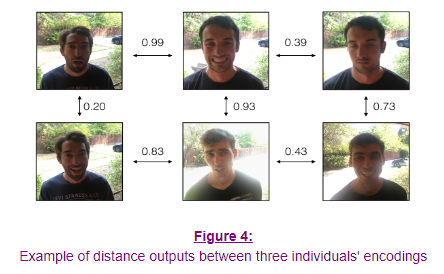

Now use this model to perform face verification and face recognition!

<a name='5'></a>
## 5 - Applying the Model

You're building a system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building.

You'd like to build a face verification system that gives access to a list of people. To be admitted, each person has to swipe an identification card at the entrance. The face recognition system then verifies that they are who they claim to be.

<a name='5-1'></a>
### 5.1 - Face Verification

Now you'll build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding, you'll use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image.

Run the following code to build the database (represented as a Python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [ ]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [ ]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Load the images of Danielle and Kian: 

In [ ]:
danielle = tf.keras.preprocessing.image.load_img("images/danielle.png", target_size=(160, 160))
kian = tf.keras.preprocessing.image.load_img("images/kian.jpg", target_size=(160, 160))

In [ ]:
np.around(np.array(kian) / 255.0, decimals=12).shape

(160, 160, 3)

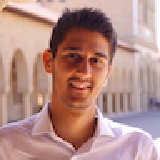

In [ ]:
kian

In [ ]:
np.around(np.array(danielle) / 255.0, decimals=12).shape

(160, 160, 3)

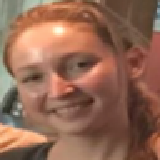

In [ ]:
danielle

Now, when someone shows up at your front door and swipes their ID card (thus giving you their name), you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

<a name='ex-2'></a>
### Exercise 2 - verify

Implement the `verify()` function, which checks if the front-door camera picture (`image_path`) is actually the person called "identity". You will have to go through the following steps:

- Compute the encoding of the image from `image_path`.
- Compute the distance between this encoding and the encoding of the identity image stored in the database.
- Open the door if the distance is less than 0.7, else do not open it.

As presented above, you should use the L2 distance `np.linalg.norm`.

**Note**: In this implementation, compare the L2 distance, not the square of the L2 distance, to the threshold 0.7.

*Hints*:

- `identity` is a string that is also a key in the database dictionary.
- `img_to_encoding` has two parameters: the image_path and model.

In [ ]:
# UNQ_C2(UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: verify

def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    ### START CODE HERE
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    ### END CODE HERE        
    return dist, door_open

Younes is trying to enter the office and the camera takes a picture of him ("images/camera_0.jpg"). Let's run your verification algorithm on this picture:

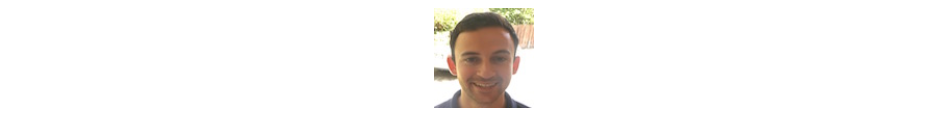

In [ ]:
# BEGIN UNIT TEST
verify("images/camera_0.jpg", "younes", database, FRmodel)
# END UNIT TEST

It's younes, welcome in!


(0.5992949, True)

**Expected Output**:

<table>
    <tr>
        <td>
            <b>It's younes, welcome in!</b>
        </td>
        <td>
           (0.5992949, True)
        </td>
    </tr>
    </table>

Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office. Naughty Benoit! The camera took a picture of Benoit ("images/camera_2.jpg). 

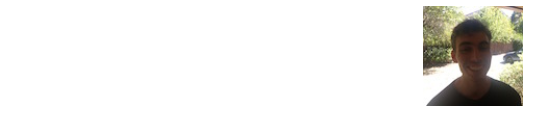

Run the verification algorithm to check if Benoit can enter.

In [ ]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(1.0259346, False)

**Expected Output**:

<table>
    <tr>
        <td>
            <b>It's not kian, please go away</b>
        </td>
        <td>
           (1.0259346, False)
        </td>
    </tr>
    </table>

<a name='5-2'></a>
### 5.2 - Face Recognition

Your face verification system is mostly working. But since Kian got his ID card stolen, when he came back to the office the next day he couldn't get in!

To solve this, you'd like to change your face verification system to a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them!

You'll implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, you will no longer get a person's name as one of the inputs.

<a name='ex-3'></a>
### Exercise 3 - who_is_it

Implement `who_is_it()` with the following steps:

- Compute the target encoding of the image from `image_path`
- Find the encoding from the database that has smallest distance with the target encoding.
- Initialize the `min_dist` variable to a large enough number (100). This helps you keep track of the closest encoding to the input's encoding.
- Loop over the database dictionary's names and encodings. To loop use for (name, db_enc) in `database.items()`.
- Compute the L2 distance between the target "encoding" and the current "encoding" from the database. If this distance is less than the min_dist, then set min_dist to dist, and identity to name.

In [ ]:
# UNQ_C3(UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: who_is_it

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE

    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding =  img_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 1000
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
    ### END CODE HERE
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Younes is at the front door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if your `who_it_is()` algorithm identifies Younes.

In [ ]:
# BEGIN UNIT TEST
# Test 1 with Younes pictures 
who_is_it("images/camera_0.jpg", database, FRmodel)

# Test 2 with Younes pictures 
test1 = who_is_it("images/camera_0.jpg", database, FRmodel)
assert np.isclose(test1[0], 0.5992946)
assert test1[1] == 'younes'

# Test 3 with Younes pictures 
test2 = who_is_it("images/younes.jpg", database, FRmodel)
assert np.isclose(test2[0], 0.0)
assert test2[1] == 'younes'
# END UNIT TEST

it's younes, the distance is 0.5992949
it's younes, the distance is 0.5992949
it's younes, the distance is 0.0


**Expected Output**:

<table>
    <tr>
        <td>
            <b>it's younes, the distance is</b> 0.5992949<br>
            <b>it's younes, the distance is</b> 0.5992949<br>
            <b>it's younes, the distance is</b> 0.0<br>
        </td>
    </tr>
    </table>

You can change "camera_0.jpg" (picture of Younes) to "camera_1.jpg" (picture of Bertrand) and see the result.

**Congratulations**! 
You've completed this assignment, and your face recognition system is working well! It not only lets in authorized persons, but now people don't need to carry an ID card around anymore!

You've now seen how a state-of-the-art face recognition system works, and can describe the difference between face recognition and face verification. Here's a quick recap of what you've accomplished: 

- Posed face recognition as a binary classification problem
- Implemented one-shot learning for a face recognition problem
- Applied the triplet loss function to learn a network's parameters in the context of face recognition
- Mapped face images into 128-dimensional encodings using a pretrained model
- Performed face verification and face recognition with these encodings

Great work! 

<font color='blue'>
    
**What you should remember**:

- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem.
    
- Triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
    
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person.

**Ways to improve your facial recognition model**:

Although you won't implement these here, here are some ways to further improve the algorithm:

- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then, given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.

- Crop the images to contain just the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.

<a name='6'></a>
## 6 - References
1. Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)

2. Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf)

3. This implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet

4. Further inspiration was found here: https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

5. And here: https://github.com/nyoki-mtl/keras-facenet/blob/master/notebook/tf_to_keras.ipynb